In [13]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [14]:
import numpy as np
import pickle
from cv2 import cv2
from os import listdir
from sklearn.preprocessing import LabelBinarizer
from keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation, Flatten, Dropout, Dense
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from keras.preprocessing import image
from keras.preprocessing.image import img_to_array
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from IPython.display import Image, display

In [15]:
EPOCHS = 22
INIT_LR = 1e-3
BS = 32
default_image_size = tuple((256, 256))
image_size = 0
directory_root = '/content/drive/MyDrive/PlantVillage1'
width=256
height=256
depth=3

In [16]:
def convert_image_to_array(image_dir):
    try:
        image = cv2.imread(image_dir)
        if image is not None :
            image = cv2.resize(image, default_image_size)   
            return img_to_array(image)
        else :
            return np.array([])
    except Exception as e:
        print(f"Error : {e}")
        return None

In [17]:
def imagepreprocessing(directory_root):
  image_list, label_list = [], []
  image_address = []
  try:
      print("[INFO] Loading images ...")
      root_dir = listdir(directory_root)
      print(root_dir)

      for plant_folder in root_dir :
          plant_disease_img = listdir(f"{directory_root}/{plant_folder}")
        
          for image in plant_disease_img:
            image_directory = f"{directory_root}/{plant_folder}/{image}"
            image_address.append(image_directory)
            if image_directory.endswith(".jpg") == True or image_directory.endswith(".JPG") == True:
              image_list.append(convert_image_to_array(image_directory))
              label_list.append(plant_folder)
      print("[INFO] Image loading completed")  
  except Exception as e:
      print(f"Error : {e}")
  # Transform the loaded training image data into numpy array
  np_image_list = np.array(image_list, dtype=np.float16) / 225
  return label_list,np_image_list,image_address,image_list

In [18]:
label_list, np_image_list, image_address, image_list = imagepreprocessing(directory_root)
image_size = len(image_list)
image_size

[INFO] Loading images ...
['Tomato_Early_blight', 'Tomato_healthy', 'Potato___healthy', 'Tomato_Late_blight', 'Potato___Late_blight', 'Potato___Early_blight']
[INFO] Image loading completed


2999

In [19]:
label_binarizer = LabelBinarizer()
image_labels = label_binarizer.fit_transform(label_list)
pickle.dump(label_binarizer,open('label_transform.pkl', 'wb'))
n_classes = len(label_binarizer.classes_)
print(n_classes)
print(label_binarizer.classes_)

6
['Potato___Early_blight' 'Potato___Late_blight' 'Potato___healthy'
 'Tomato_Early_blight' 'Tomato_Late_blight' 'Tomato_healthy']


In [20]:
print("[INFO] Spliting data to train, test")
x_train, x_test, y_train, y_test = train_test_split(np_image_list, image_labels, test_size=0.2, random_state = 42) 

[INFO] Spliting data to train, test


In [21]:
aug = ImageDataGenerator(
    rotation_range=25, width_shift_range=0.1,
    height_shift_range=0.1, shear_range=0.2, 
    zoom_range=0.2,horizontal_flip=True, 
    fill_mode="nearest")

In [22]:
model = Sequential()
inputShape = (height, width, depth)
chanDim = -1
if K.image_data_format() == "channels_first":
    inputShape = (depth, height, width)
    chanDim = 1
model.add(Conv2D(32, (3, 3), padding="same",input_shape=inputShape))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Dropout(0.25))
model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(128, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(Conv2D(128, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(1024))
model.add(Activation("relu"))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(n_classes))
model.add(Activation("softmax"))

In [23]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 32)      896       
                                                                 
 activation (Activation)     (None, 256, 256, 32)      0         
                                                                 
 batch_normalization (BatchN  (None, 256, 256, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 85, 85, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 85, 85, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 85, 85, 64)        1

In [24]:
opt = Adam(learning_rate=INIT_LR, decay=INIT_LR / EPOCHS)
# distribution
model.compile(loss="binary_crossentropy", optimizer=opt,metrics=["accuracy"])
# train the network
print("[INFO] training network...")

[INFO] training network...


In [25]:
history = model.fit(
  aug.flow(x_train, y_train, batch_size=BS),
  validation_data=(x_test, y_test), 
  steps_per_epoch=len(x_train) // BS,
  epochs=EPOCHS, verbose=1
    )

Epoch 1/22
74/74 [==============================] - 544s 7s/step - loss: 0.5342 - accuracy: 0.6565 - val_loss: 0.6947 - val_accuracy: 0.1467
Epoch 2/22
74/74 [==============================] - 542s 7s/step - loss: 0.2105 - accuracy: 0.7972 - val_loss: 1.9316 - val_accuracy: 0.1500
Epoch 3/22
74/74 [==============================] - 538s 7s/step - loss: 0.1522 - accuracy: 0.8488 - val_loss: 0.7012 - val_accuracy: 0.3500
Epoch 4/22
74/74 [==============================] - 534s 7s/step - loss: 0.1566 - accuracy: 0.8403 - val_loss: 1.0929 - val_accuracy: 0.3517
Epoch 5/22
74/74 [==============================] - 536s 7s/step - loss: 0.1626 - accuracy: 0.8390 - val_loss: 1.5164 - val_accuracy: 0.2383
Epoch 6/22
74/74 [==============================] - 541s 7s/step - loss: 0.1452 - accuracy: 0.8699 - val_loss: 1.5482 - val_accuracy: 0.3317
Epoch 7/22
74/74 [==============================] - 542s 7s/step - loss: 0.1325 - accuracy: 0.8673 - val_loss: 0.3331 - val_accuracy: 0.7000
Epoch 8/22
74

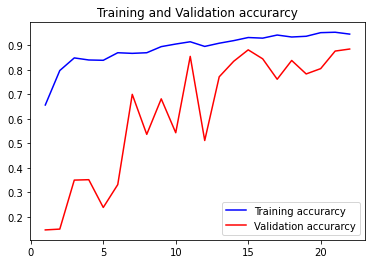

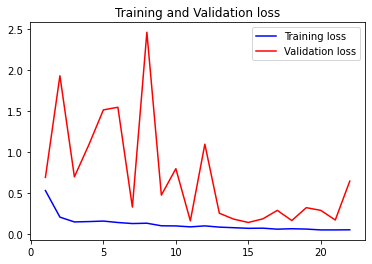

In [26]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
#Train and validation accuracy
plt.plot(epochs, acc, 'b', label='Training accurarcy')
plt.plot(epochs, val_acc, 'r', label='Validation accurarcy')
plt.title('Training and Validation accurarcy')
plt.legend()

plt.figure()
#Train and validation loss
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()

In [27]:
print("[INFO] Calculating model accuracy")
scores = model.evaluate(x_test, y_test)
print(f"Test Accuracy: {scores[1]*100}")

[INFO] Calculating model accuracy
19/19 [==============================] - 28s 1s/step - loss: 0.6491 - accuracy: 0.8850
Test Accuracy: 88.49999904632568


In [30]:
# save the model to disk
print("[INFO] Saving model...")
pickle.dump(model,open('cnn_model.pkl', 'wb'))
!mkdir -p saved_model
model.save('saved_model/my_model') 

[INFO] Saving model...
INFO:tensorflow:Assets written to: ram://01cc6e28-849d-47f5-b35e-9c121c1358ef/assets
INFO:tensorflow:Assets written to: saved_model/my_model/assets


[INFO] Loading images ...
['Tomato_Early_blight', 'Tomato_Late_blight', 'Potato___Late_blight', 'Tomato_healthy', 'Potato___healthy', 'Potato___Early_blight']
[INFO] Image loading completed


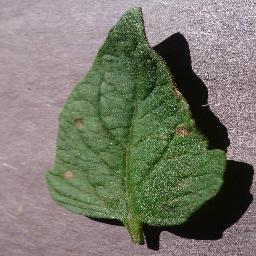

This image is of class = Tomato_Early_blight And the predicted class is  Tomato_Early_blight




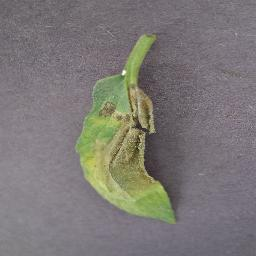

This image is of class = Tomato_Late_blight And the predicted class is  Tomato_Late_blight




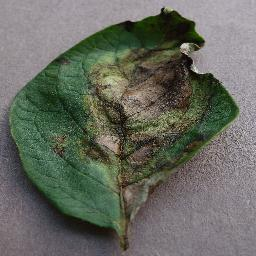

This image is of class = Potato___Late_blight And the predicted class is  Potato___Late_blight




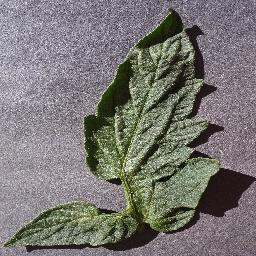

This image is of class = Tomato_healthy And the predicted class is  Tomato_healthy




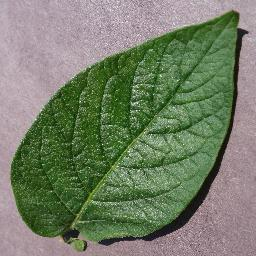

This image is of class = Potato___healthy And the predicted class is  Potato___healthy




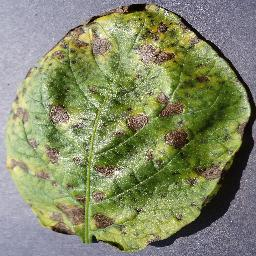

This image is of class = Potato___Early_blight And the predicted class is  Potato___Early_blight




In [32]:
# Detecting leaf images
directory_root = '/content/drive/MyDrive/PlantVillagePrediction'
label_list, np_image_list, image_address, image_list = imagepreprocessing(directory_root)

predictions = model.predict(np_image_list)
labels = (predictions > 0.5).astype(np.int)
y_pred = label_binarizer.inverse_transform(labels)
for i in range(0,6):
  display(Image(image_address[i]))
  print("This image is of class =", label_list[i], "And the predicted class is ", y_pred[i])
  print("\n")